# Mask creation

This notebook uses the sparse pixel annotations (always in the `annotations.csv` file) 
from the CoralNet website, and creates a **mask** for each image.

The annotations are given in the following order: `row, column, label` -> `height, width, label`.

The image shapes are in the same order: `height, width, channels`.

! quick reminder !

numpy image: H x W x C

torch image: C x H x W

To create the masks, the `labelset.csv` is going to be used.

*I am going to use all the labels provided by the sources (even if they are not in the "verified" labels), 
because the images have been selected to the "confirmed".*

## Import necessary libraries

In [1]:
from PIL import Image
from skimage import io, transform
from sklearn.preprocessing import MinMaxScaler  

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch

## Get data from the chosen source

In [121]:
# go to the source
os.chdir("/data/jantina/CoralNet/used/BHP_GSR_Fiji/other")

# prepare annotations
annotations = pd.read_csv('annotations.csv')
img_names = annotations.iloc[:, 0]
landmarks = annotations.iloc[:, 1:4]

# prepare labels as dictionary
# using numbers from 1 -> N
labels = pd.read_csv('labelset.csv')["Short Code"]
labels.index = labels.index + 1
labels = labels.to_dict()

print(f"[INFO] There are {len(img_names.unique())} images in this source")
print(f"[INFO] There are {len(labels)} labels in this source")

[INFO] There are 1268 images in this source
[INFO] There are 149 labels in this source


In [122]:
labels

{1: 'ACOR',
 2: 'ACOR-BL',
 3: 'ACSP',
 4: 'ACSP-BL',
 5: 'ADIG',
 6: 'ADIG-BL',
 7: 'AHUM',
 8: 'AMPH',
 9: 'AMUR',
 10: 'AMUR-BL',
 11: 'ANEM',
 12: 'APLA',
 13: 'APUL',
 14: 'APUL-BL',
 15: 'ASPE-BL',
 16: 'ASTA',
 17: 'ASTA-BL',
 18: 'ASTE',
 19: 'ATSP',
 20: 'BOOD',
 21: 'BRCA',
 22: 'CARA',
 23: 'CASE',
 24: 'CAST',
 25: 'CATA',
 26: 'CAUL',
 27: 'CHFR',
 28: 'CNOV',
 29: 'CORA',
 30: 'CORA-BL',
 31: 'CCA',
 32: 'CSPE',
 33: 'CSPE-BL',
 34: 'CTSP',
 35: 'CYAN',
 36: 'CYSP',
 37: 'DEAD',
 38: 'DEST',
 39: 'DICT',
 40: 'DPHE',
 41: 'DPHE-BL',
 42: 'DPSP',
 43: 'DPSP-BL',
 44: 'DYSI',
 45: 'ECHN',
 46: 'FAVS',
 47: 'FAVS-BL',
 48: 'FISH',
 49: 'FUSP',
 50: 'FUSP-BL',
 51: 'GARB',
 52: 'GFAS',
 53: 'GFAS-BL',
 54: 'GNSP',
 55: 'GPSP',
 56: 'GPSP-BL',
 57: 'GRET',
 58: 'GRET-BL',
 59: 'GSTE',
 60: 'GSTE-BL',
 61: 'HALI',
 62: 'HAMA',
 63: 'HCOE',
 64: 'HESP',
 65: 'HESP-BL',
 66: 'HMIC',
 67: 'HMIC-BL',
 68: 'HOLO',
 69: 'INVE',
 70: 'LESP',
 71: 'LESP-BL',
 72: 'LILA',
 73: 'LMUL',
 

In [120]:
# go to the source
os.chdir("/data/jantina/CoralNet/used/BHP_GSR_Fiji/other")

# prepare annotations
annotations = pd.read_csv('annotations.csv')
img_names = annotations.iloc[:, 0]

for img_name in img_names.unique():
    # go to root
    os.chdir("/data/jantina/CoralNet/used/BHP_GSR_Fiji")
    # get image
    image = io.imread(os.path.join('images', img_name))
    print(image.shape)

(849, 584, 3)
(849, 584, 3)
(849, 584, 3)
(849, 584, 3)
(849, 584, 3)
(849, 584, 3)
(849, 584, 3)
(849, 584, 3)
(849, 584, 3)
(849, 584, 3)
(1071, 2217, 3)
(1071, 2217, 3)
(1071, 2217, 3)
(1071, 2217, 3)
(1071, 2216, 3)
(1070, 2217, 3)
(1070, 2217, 3)
(1070, 2217, 3)
(1070, 2217, 3)
(1070, 2216, 3)
(1531, 689, 3)
(1531, 689, 3)
(1531, 689, 3)
(1531, 689, 3)
(1531, 689, 3)
(1531, 689, 3)
(1531, 689, 3)
(1531, 689, 3)
(1529, 689, 3)
(1529, 689, 3)
(624, 854, 3)
(624, 854, 3)
(624, 854, 3)
(624, 854, 3)
(624, 854, 3)
(624, 854, 3)
(624, 854, 3)
(624, 854, 3)
(624, 854, 3)
(615, 854, 3)
(779, 2129, 3)
(779, 2129, 3)
(779, 2129, 3)
(779, 2129, 3)
(779, 2128, 3)
(779, 2129, 3)
(779, 2129, 3)
(779, 2129, 3)
(779, 2129, 3)
(779, 2128, 3)
(1377, 822, 3)
(1377, 821, 3)
(1377, 822, 3)
(1377, 821, 3)
(1377, 822, 3)
(1377, 821, 3)
(1377, 822, 3)
(1377, 821, 3)
(1375, 822, 3)
(1375, 821, 3)
(724, 472, 3)
(724, 472, 3)
(724, 472, 3)
(724, 472, 3)
(724, 472, 3)
(724, 472, 3)
(724, 472, 3)
(724, 472, 3

(756, 840, 3)
(756, 840, 3)
(756, 840, 3)
(756, 840, 3)
(595, 1458, 3)
(595, 1458, 3)
(595, 1458, 3)
(595, 1458, 3)
(595, 1458, 3)
(595, 1458, 3)
(595, 1458, 3)
(595, 1458, 3)
(595, 1458, 3)
(595, 1458, 3)
(657, 740, 3)
(657, 740, 3)
(657, 740, 3)
(657, 740, 3)
(657, 740, 3)
(657, 740, 3)
(657, 740, 3)
(657, 740, 3)
(657, 740, 3)
(652, 740, 3)
(786, 350, 3)
(786, 350, 3)
(786, 350, 3)
(786, 350, 3)
(786, 350, 3)
(786, 350, 3)
(786, 350, 3)
(786, 350, 3)
(786, 350, 3)
(786, 350, 3)
(834, 400, 3)
(834, 400, 3)
(834, 400, 3)
(834, 400, 3)
(834, 400, 3)
(834, 400, 3)
(834, 400, 3)
(834, 400, 3)
(834, 400, 3)
(834, 400, 3)
(770, 1230, 3)
(770, 1230, 3)
(770, 1230, 3)
(770, 1230, 3)
(770, 1230, 3)
(770, 1230, 3)
(770, 1230, 3)
(770, 1230, 3)
(770, 1230, 3)
(770, 1230, 3)
(984, 1180, 3)
(984, 1180, 3)
(984, 1180, 3)
(984, 1180, 3)
(984, 1180, 3)
(984, 1180, 3)
(984, 1180, 3)
(984, 1180, 3)
(984, 1180, 3)
(984, 1180, 3)
(776, 700, 3)
(776, 700, 3)
(776, 700, 3)
(776, 700, 3)
(776, 700, 3)
(776

(534, 915, 3)
(534, 915, 3)
(534, 915, 3)
(534, 915, 3)
(534, 915, 3)
(529, 915, 3)
(632, 192, 3)
(632, 192, 3)
(632, 192, 3)
(632, 192, 3)
(632, 192, 3)
(632, 192, 3)
(632, 192, 3)
(632, 192, 3)
(624, 192, 3)
(460, 1293, 3)
(460, 1293, 3)
(460, 1293, 3)
(460, 1293, 3)
(460, 1292, 3)
(459, 1293, 3)
(459, 1293, 3)
(459, 1293, 3)
(459, 1293, 3)
(459, 1292, 3)
(1242, 467, 3)
(1242, 466, 3)
(1242, 467, 3)
(1242, 466, 3)
(1242, 467, 3)
(1242, 466, 3)
(1242, 467, 3)
(1242, 466, 3)
(1241, 467, 3)
(1241, 466, 3)
(926, 806, 3)
(926, 806, 3)
(926, 806, 3)
(926, 806, 3)
(926, 806, 3)
(926, 806, 3)
(926, 806, 3)
(926, 806, 3)
(926, 806, 3)
(926, 806, 3)
(975, 812, 3)
(975, 812, 3)
(975, 812, 3)
(975, 812, 3)
(975, 812, 3)
(975, 812, 3)
(975, 812, 3)
(975, 812, 3)
(975, 812, 3)
(972, 812, 3)
(964, 779, 3)
(964, 779, 3)
(964, 779, 3)
(964, 779, 3)
(964, 779, 3)
(964, 779, 3)
(964, 779, 3)
(964, 779, 3)
(964, 779, 3)
(963, 779, 3)
(1797, 800, 3)
(1797, 800, 3)
(1797, 800, 3)
(1797, 800, 3)
(1797, 800

## Create masks for all images in that source

In [4]:
for img_name in img_names.unique():
    # go to root
    os.chdir("/data/jantina/CoralNet/used/Hamad_New")
    # get image
    try:
        image = io.imread(os.path.join('images', img_name))
        # retrieve the annotations for that image
        landmark = landmarks.iloc[img_names[img_names==img_name].index.values]
        landmark = np.asarray(landmark)

        # get image information
        height = image.shape[0]
        width = image.shape[1]
        colors = image.shape[2]

        # create array with coordinates and label code
        classes = np.copy(landmark) 
        for new, old in labels.items():
            classes[landmark == old] = new

        # create mask 
        mask = np.full((height, width), 255)
        for x in classes:
            try:
                mask[x[0], x[1]] = x[2]
            except:
                print(img_name)
                print("These labels are out of bounds", x[0], x[1], x[2])
                continue

        # switch to png to not loose information
        img_name = img_name.split(".JPG")[0]+".png"

        # check the labels contained in the mask
        print(img_name, np.unique(mask))

        # save mask
        os.chdir("/data/jantina/CoralNet/used/Hamad_New/masks")
        cv2.imwrite(img_name, mask)

        # load the mask and check the labels again
        # if they don't match there is a problem
        image = cv2.imread(os.path.join(img_name))
        print(img_name, np.unique(image))
    except:
        continue

ALM1Q10.png [ 78 120 145 147 204 255]
ALM1Q10.png [ 78 120 145 147 204 255]
ALM1Q11.png [ 78 120 147 255]
ALM1Q11.png [ 78 120 147 255]
ALM1Q12.png [ 78 120 145 207 255]
ALM1Q12.png [ 78 120 145 207 255]
ALM1Q13.png [120 207 255]
ALM1Q13.png [120 207 255]
ALM1Q14.png [120 145 147 199 255]
ALM1Q14.png [120 145 147 199 255]
ALM1Q15.png [ 78 120 145 147 207 255]
ALM1Q15.png [ 78 120 145 147 207 255]
ALM1Q1.png [ 78 120 147 255]
ALM1Q1.png [ 78 120 147 255]
ALM1Q2.png [ 78 120 145 147 255]
ALM1Q2.png [ 78 120 145 147 255]
ALM1Q3.png [ 78 120 147 255]
ALM1Q3.png [ 78 120 147 255]
ALM1Q4.png [120 255]
ALM1Q4.png [120 255]
ALM1Q5.png [120 132 145 147 199 255]
ALM1Q5.png [120 132 145 147 199 255]
ALM1Q6.png [ 78 120 145 147 255]
ALM1Q6.png [ 78 120 145 147 255]
ALM1Q7.png [120 255]
ALM1Q7.png [120 255]
ALM1Q8.png [ 78 120 147 255]
ALM1Q8.png [ 78 120 147 255]
ALM1Q9.png [ 78 120 147 255]
ALM1Q9.png [ 78 120 147 255]
ALM2Q10.png [ 78 120 199 255]
ALM2Q10.png [ 78 120 199 255]
ALM2Q11.png [ 78 1

## Rotating images

Some images might have tilted when being download, thus the annotations won't match. 

The message `These labels are out of bounds` will appear for these images.

These images will need to be rotated first !

In [ ]:
# go to root
os.chdir("/data/jantina/CoralNet/used/Hamad_New")

# take a single image
img_name = "ALM2Q14.JPG"
image = io.imread(os.path.join('images', img_name))
print(image.shape)
plt.imshow(image)

# retrieve the annotations for that image
landmark = landmarks.iloc[img_names[img_names==img_name].index.values]
landmark = np.asarray(landmark)

# rotate
img = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
print(img.shape)
plt.imshow(img)

# replace the current image
os.chdir("/data/jantina/CoralNet/used/Hamad_New/images")
cv2.imwrite(img_name, img)

## Converting RGBA to RGB

In [ ]:
for img_name in img_names.unique():
    # go to root
    os.chdir("/data/jantina/CoralNet/dataset")
    image = Image.open(os.path.join('images', img_name))
    rgb_image = image.convert('RGB')
    # replace the current image
    os.chdir("/data/jantina/CoralNet/dataset/images")
    rgb_image.save(img_name)

## Plot a single image with annotations

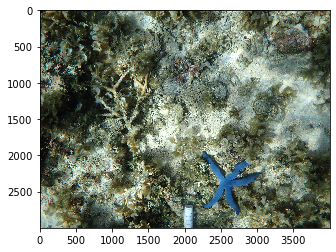

In [111]:
# go to root
os.chdir("/data/jantina/CoralNet/used/WAPA_RFM")
annotations = pd.read_csv('other/annotations.csv')
img_names = annotations.iloc[:, 0]
landmarks = annotations.iloc[:, 1:4]

# take a single image
img_name = "2021-11-20-ADELUP-A-T4 20.5-B (PB200870).JPG"

# retrieve the annotations for that image
landmarks = annotations.iloc[:, 1:3]
landmarks = landmarks.iloc[img_names[img_names==img_name].index.values]
landmarks = np.asarray(landmarks).astype('float').reshape(-1, 2)

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    #plt.scatter(landmarks[:, 1], landmarks[:, 0], s=50, marker='.', c='r')

# show the image with it's annotations
plt.figure()
show_landmarks(io.imread(os.path.join('images', img_name)),landmarks)
plt.show()

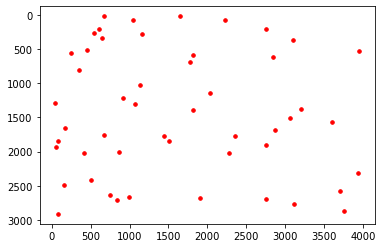

In [110]:
plt.figure()
scatter = plt.scatter(landmarks[:, 1], landmarks[:, 0], s=50, marker='.', c='r')
ax = scatter.axes
ax.invert_yaxis()
plt.show()